# KOH Posterior Analysis using Mici

In [1]:
from models import toymodel as KOHmodel
from data.dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from jax import jit, grad

import numpy as np
import matplotlib.pyplot as plt

import mici
import arviz

from truefuncs import zeta
eta = zeta

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


# The data

In [2]:
dataloader = DataLoader('data/toy/field_growing.csv', 'data/toy/sim_growing.csv')
data = dataloader.get_data()
model = KOHmodel.Model(*data)

tmax = dataloader.t_max
tmin = dataloader.t_min

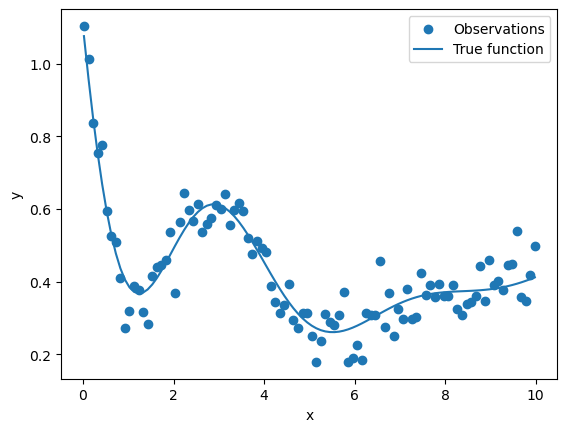

In [3]:
fig, ax = plt.subplots(1, 1)
ax.scatter(dataloader.xf, dataloader.yf, label='Observations')
def disc(x):
    return np.exp(0.14*x)/10
ax.plot(dataloader.xf, zeta(dataloader.xf, 0.4)+disc(dataloader.xf), label='True function')
# for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
#     rows = dataloader.tc==t
#     ax.plot(dataloader.xc[rows], dataloader.yc[rows], '--', label=f'Simulator t={t}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

# MCMC Setup

In [4]:
theta_0 = 0.5

ell_eta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/3
ell_eta_1_0 = 0.3 # np.sqrt(np.var(dataloader.tc))/3
ell_delta_0_0 = 1 # np.sqrt(np.var(dataloader.xf))/5

lambda_eta_0 = 1
lambda_delta_0 = 30
lambda_epsilon_0 = 400
lambda_epsilon_eta_0 = 10000

init_states = np.array([[
    map01toR(theta_0), 
    map0inftoR(ell_eta_0_0),
    map0inftoR(ell_eta_1_0),
    map0inftoR(ell_delta_0_0),
    map0inftoR(lambda_eta_0),
    map0inftoR(lambda_delta_0),
    map0inftoR(lambda_epsilon_0),
    map0inftoR(lambda_epsilon_eta_0),
]])

Build the transform function to translate Mici's unbounded parameters into bounded GPJAX parameters.
This is passed to KOHGPJax.

In [5]:
param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0]),
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
        mapRto0inf(x[3]),
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6]), 
        mapRto0inf(x[7]),
    ]
]

Build the function for evaluating the negative log posterior density.

This function is jitted and grad jitted using JAX. Finally the JAX functions are wrapped into a numpy function for clean interactions with Mici.

In [6]:
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(grad(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
))

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

# Running MCMC algorithm

In [7]:
seed = 1234
n_chain = 1
n_warm_up_iter = 200
n_main_iter = 500
rng = np.random.default_rng(seed)

##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=3)
# sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'm_theta': state.pos[0], 
        'm_ell_eta_0': state.pos[1], 
        'm_ell_eta_1': state.pos[2],
        'm_ell_delta_0': state.pos[3],
        'm_lambda_eta': state.pos[4],
        'm_lambda_delta': state.pos[5],
        'm_lambda_epsilon': state.pos[6],
        'm_lambda_epsilon_eta': state.pos[7],
        'hamiltonian': system.h(state)
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:10] > Slow adaptive (1/2) [00:03] > Slow adaptive (2/2) [00:05] > Final fast adaptive [00:05] > Main non-adaptive [00:57]

Chain 1/1: 100%|██████████|500/500 [00:57<00:00, 8.69it/s, accept_stat=0.818]

# Analyse MCMC output

In [8]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_theta,0.375,0.171,0.082,0.737,0.036,0.026,30.0,126.0,NaN
m_ell_eta_0,0.781,0.033,0.718,0.837,0.003,0.002,92.0,184.0,NaN
m_ell_eta_1,-1.305,0.041,-1.377,-1.216,0.005,0.004,60.0,188.0,NaN
m_ell_delta_0,0.897,0.273,0.406,1.389,0.034,0.024,66.0,164.0,NaN
m_lambda_eta,-1.351,0.317,-1.917,-0.755,0.050,0.041,45.0,122.0,NaN
m_lambda_delta,3.146,0.305,2.570,3.646,0.056,0.040,31.0,174.0,NaN
m_lambda_epsilon,5.858,0.126,5.644,6.115,0.011,0.008,131.0,158.0,NaN
m_lambda_epsilon_eta,12.217,0.073,12.092,12.366,0.004,0.003,407.0,315.0,NaN
hamiltonian,-2236.730,2.982,-2241.731,-2231.311,0.228,0.161,160.0,249.0,NaN


In [9]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

m_theta :  0.37457680227884393 ± 0.17092112223651773
m_ell_eta_0 :  0.7807079468680281 ± 0.032944209358948984
m_ell_eta_1 :  -1.3053088075796657 ± 0.04091000210950353
m_ell_delta_0 :  0.8966243681626179 ± 0.2722772743970493
m_lambda_eta :  -1.3505794357994214 ± 0.31650949434000303
m_lambda_delta :  3.1463436275932644 ± 0.30459598223799395
m_lambda_epsilon :  5.858176485888992 ± 0.12547046444112592
m_lambda_epsilon_eta :  12.217238700983485 ± 0.07312435576041453
hamiltonian :  -2236.7297990603406 ± 2.9788251187151604


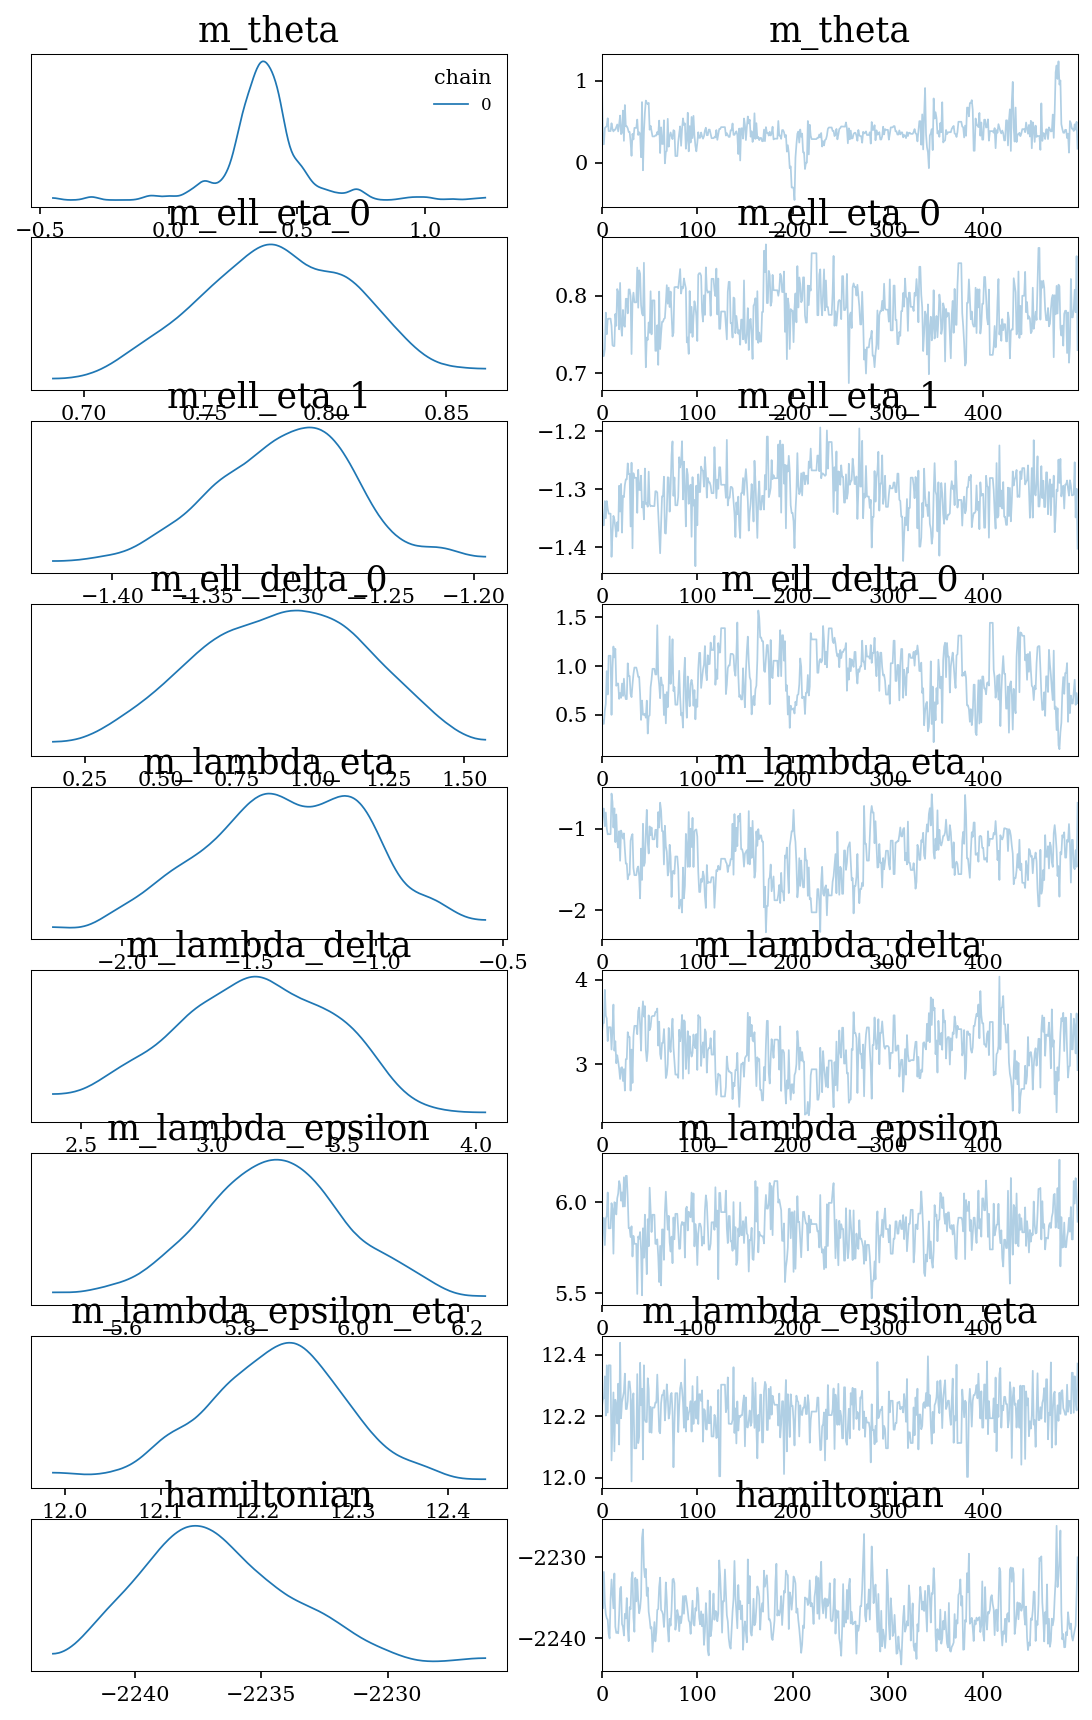

In [10]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [11]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'hamiltonian':
        continue
    var_name = var.split('m_')[1]
    if var_name == 'theta':
        traces_transformed[var_name] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var_name.startswith('ell'):
        traces_transformed[var_name] = mapRto0inf(trace[0])
    elif var_name.startswith('lambda'):
        traces_transformed[var_name] = mapRto0inf(trace[0])

params_transformed = {}
for var, trace in traces_transformed.items():
    params_transformed[var] = np.mean(trace)
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.3975461607780986 ± 0.03871373046637226
ell_eta_0 :  2.1842020581034887 ± 0.0719646456724531
ell_eta_1 :  0.2713152994232898 ± 0.011071266941366667
ell_delta_0 :  2.5424799986211943 ± 0.6844447317524145
lambda_eta :  0.27214308290822187 ± 0.08523365228672586
lambda_delta :  24.334015602655242 ± 7.3258783349043215
lambda_epsilon :  352.84111405930224 ± 44.18720753434677
lambda_epsilon_eta :  202783.8959849655 ± 14715.778268808941


In [12]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.398,0.039,0.316,0.466,0.008,0.006,30.0,126.0,NaN
ell_eta_0,2.184,0.072,2.050,2.310,0.008,0.005,92.0,184.0,NaN
ell_eta_1,0.271,0.011,0.246,0.289,0.001,0.001,60.0,188.0,NaN
ell_delta_0,2.542,0.685,1.372,3.729,0.085,0.060,66.0,164.0,NaN
lambda_eta,0.272,0.085,0.131,0.440,0.012,0.009,45.0,86.0,NaN
lambda_delta,24.334,7.333,12.590,37.214,1.254,0.894,31.0,174.0,NaN
lambda_epsilon,352.841,44.231,268.823,437.293,3.885,2.775,131.0,158.0,NaN
lambda_epsilon_eta,202783.896,14730.516,177231.492,233173.309,730.667,517.724,407.0,315.0,NaN


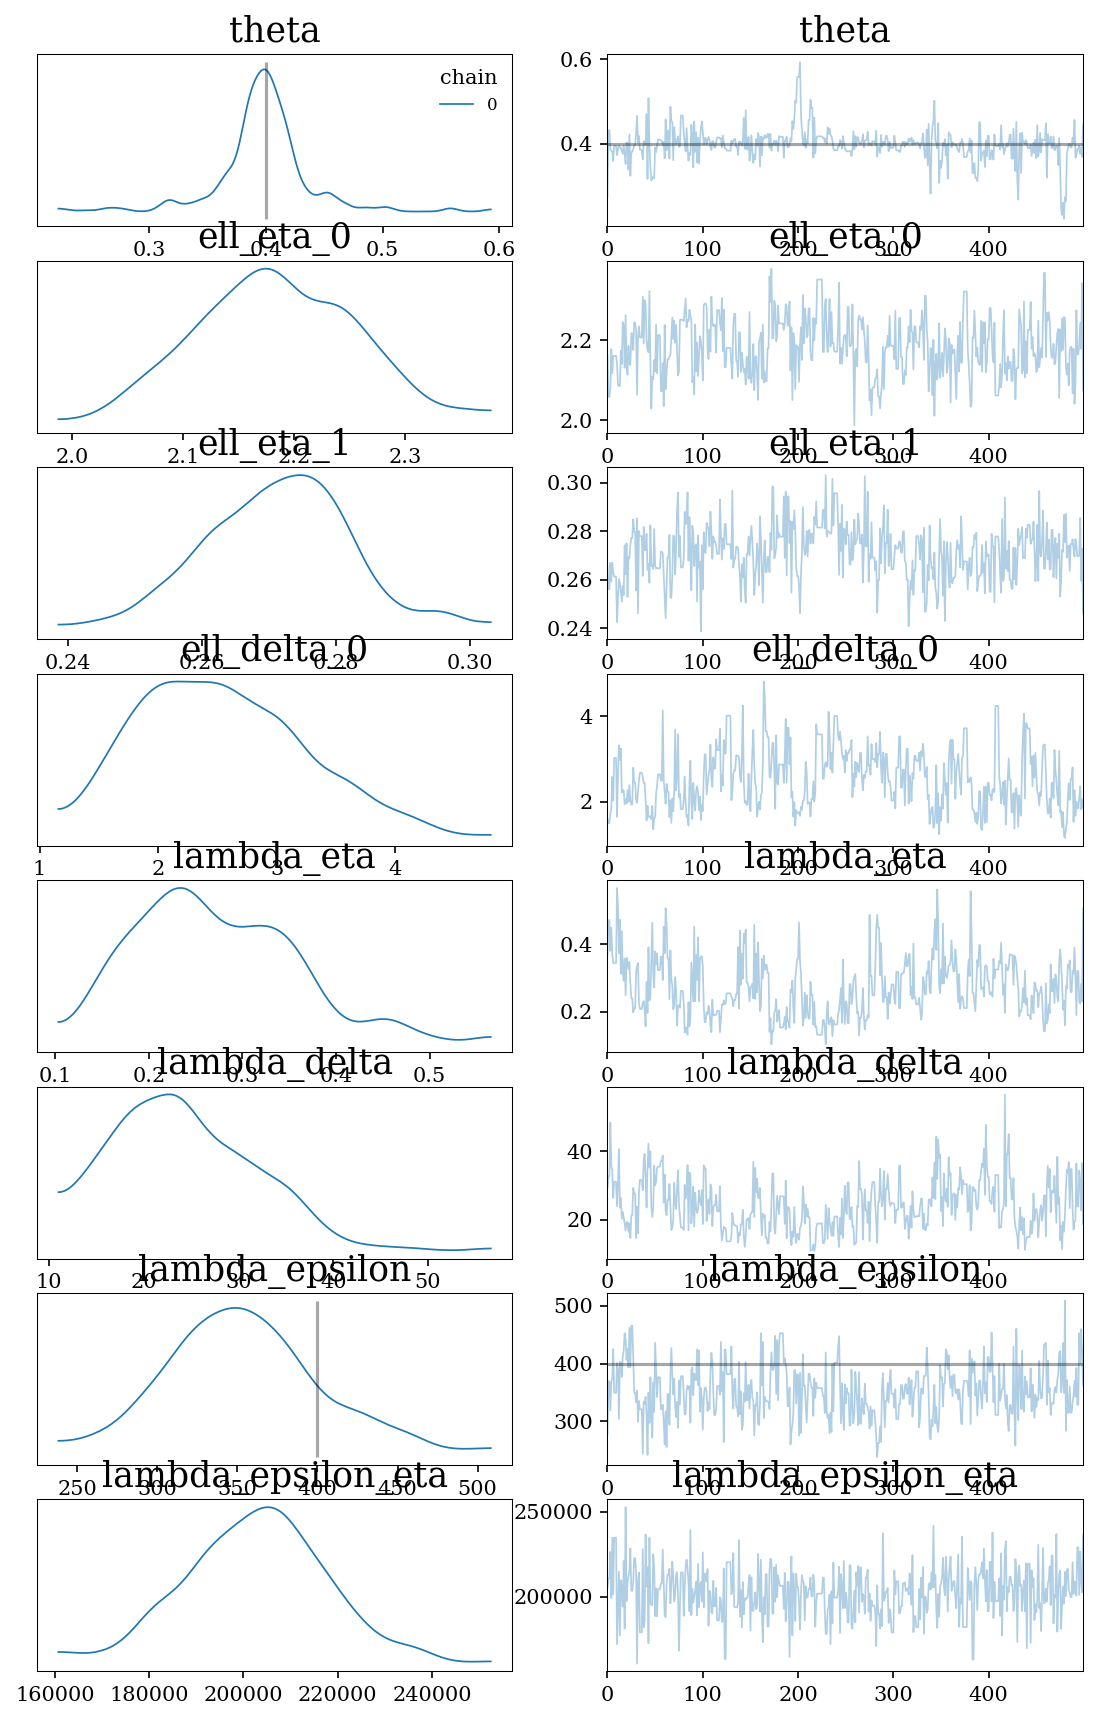

In [13]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
        lines=(
            ('theta', {}, 0.4),
            ('lambda_epsilon', {}, 1/0.05**2)    
        )
    )
plt.show()

# Analyse posterior fit

## Prediction data

In [14]:
posterior_eta_predictions = np.loadtxt("data/matlab/posterior_eta_predictions.csv", delimiter=",", dtype=float)
xpred = posterior_eta_predictions[:,0]

# xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(np.mean(traces['m_theta'])) # transform theta back to [0, 1]

# x_test = np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T
# dataset = model.dataset(theta_transformed)
x_test = np.vstack((xpred, theta_transformed*np.ones_like(xpred))).T
dataset = model.dataset(theta_transformed)

## Posterior GPs

In [15]:
GP_posterior = model.GP_posterior(
    param_transform_mici_to_gpjax(
        [np.mean(x) for x in traces.values()]
    )
)

eta_pred = GP_posterior.predict_eta(
    x_test,
    dataset
)
zeta_pred = GP_posterior.predict_zeta(
    x_test,
    dataset
)
obs_pred = GP_posterior.predict_obs(
    x_test,
    dataset
)


# eta_pred_m = dataloader.inverse_transform_y(eta_pred.mean()) # transform back to original scale
# eta_pred_v = dataloader.inverse_transform_y_cov(eta_pred.variance()) # transform back to original scale
eta_pred_m = eta_pred.mean() + dataloader.yc_mean
eta_pred_v = eta_pred.variance()
eta_pred_sd = np.sqrt(eta_pred_v)

zeta_pred_m = zeta_pred.mean() + dataloader.yc_mean
zeta_pred_v = zeta_pred.variance()
zeta_pred_sd = np.sqrt(zeta_pred_v)

# obs_pred_m = dataloader.inverse_transform_y(obs_pred.mean()) # transform back to original scale
# obs_pred_v = dataloader.inverse_transform_y_cov(obs_pred.variance()) # transform back to original scale
obs_pred_m = obs_pred.mean() + dataloader.yc_mean
obs_pred_v = obs_pred.variance()
obs_pred_sd = np.sqrt(obs_pred_v)




x = np.linspace(0, 10, 500)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

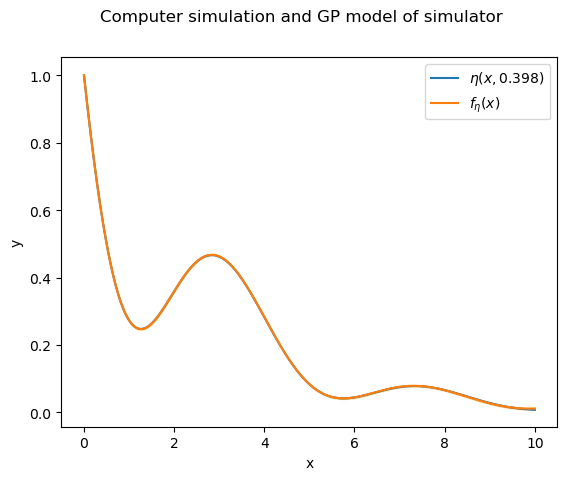

In [16]:
theta = params_transformed['theta']

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, eta(x, theta), label=fr'$\eta(x, {theta:.3f})$')
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='orange'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

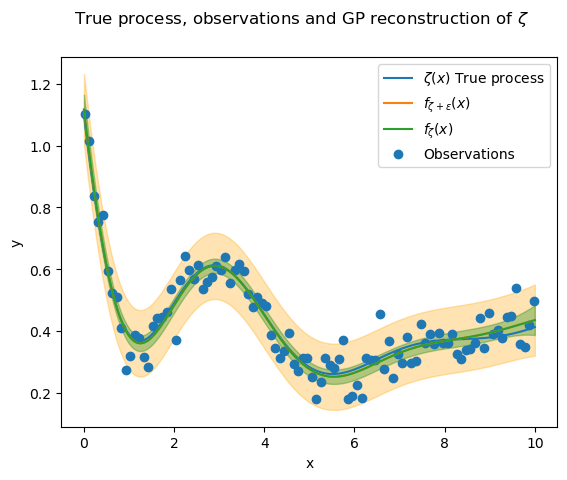

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(x, zeta(x)+disc(x), label=r'$\zeta(x)$ True process')
ax.plot(xpred, obs_pred_m, label=r'$f_{\zeta+\epsilon}(x)$')
ax.fill_between(
    xpred, 
    obs_pred_m-1.96*obs_pred_sd, 
    obs_pred_m+1.96*obs_pred_sd, 
    alpha=0.3, 
    color='orange'
)
ax.plot(xpred, zeta_pred_m, label=r'$f_{\zeta}(x)$')
ax.fill_between(
    xpred, 
    zeta_pred_m-1.96*zeta_pred_sd, 
    zeta_pred_m+1.96*zeta_pred_sd, 
    alpha=0.3, 
    color='green'
)
ax.scatter(dataloader.xf, dataloader.yf, label="Observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Model discrepancy

Interpret the next figure as follows. "True discrepancy" is the actual difference between the functions used to generate the simulation output and the observations. The blue line is the function the code is trying to learn. According to the MCMC samples, $\delta(x)$ should be the blue line. $f_\delta(x)$ is the attempt to learn the blue line.

Notice the uncertainty of the GP is very large and always encompases the true discrepancy function, $0$ for all $x$.

In [18]:
delta_gp_m = zeta_pred_m - eta_pred_m
delta_gp_v = zeta_pred_v + eta_pred_v
delta_gp_sd = np.sqrt(delta_gp_v)

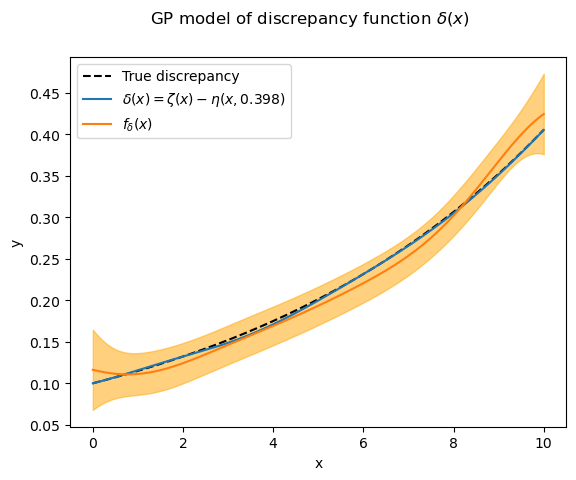

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# ax.hlines(0.14, 0, 10, color='black', linestyle='--', label='True discrepancy')
ax.plot(x, disc(x), color='black', linestyle='--', label='True discrepancy')
ax.plot(x, zeta(x)+disc(x) - eta(x, theta), label=rf'$\delta(x) = \zeta(x) - \eta(x, {theta:.3f})$')
ax.plot(xpred, delta_gp_m, label=r'$f_\delta(x)$')
ax.fill_between(
    xpred, 
    delta_gp_m-1.96*delta_gp_sd, 
    delta_gp_m+1.96*delta_gp_sd, 
    alpha=0.5, 
    color='orange'
)

ax.legend()
fig.suptitle("GP model of discrepancy function $\delta(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()